In [1]:
import networkx as nx
import scipy.stats as sp
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
import powerlaw
import mpmath
from itertools import product

In [2]:
from helpful_functions import *

In [3]:
K = ig.Graph.Read_GML('human-disease.gml')

In [4]:
pp =  nx.Graph(K.to_networkx())

#### All Classes:

In [5]:
classes = list(dict(pp.nodes.data('disclass')).values())
print('Classes:')
print()
for c in set(classes):
    print(f'   - {c}')
print()
print('Number of classes:', len(set(classes)))

Classes:

   - Unclassified
   - Cancer
   - Hematological
   - Respiratory
   - Immunological
   - Ear,Nose,Throat
   - Cardiovascular
   - Bone
   - Muscular
   - Endocrine
   - Gastrointestinal
   - Neurological
   - Psychiatric
   - Nutritional
   - Connective tissue disorder
   - Metabolic
   - Multiple
   - Skeletal
   - Renal
   - Developmental
   - Ophthamological
   - Dermatological

Number of classes: 22


#### Number of Nodes per Class:

In [6]:
npn = Counter(classes)
s_npn = dict(sorted(npn.items(), key=lambda x: x[1], reverse=True))
for n, s in s_npn.items():
    print(f"- {n}: {s}")
    
print()
print('Number of Nodes:', len(pp))

- Cancer: 88
- Neurological: 55
- Multiple: 54
- Ophthamological: 39
- Hematological: 34
- Metabolic: 32
- Cardiovascular: 27
- Endocrine: 27
- Immunological: 24
- Skeletal: 23
- Dermatological: 21
- Muscular: 15
- Connective tissue disorder: 15
- Bone: 15
- Unclassified: 9
- Renal: 8
- Psychiatric: 8
- Developmental: 8
- Respiratory: 4
- Gastrointestinal: 4
- Ear,Nose,Throat: 3
- Nutritional: 3

Number of Nodes: 516


## Properties:

### Average Degree

In [7]:
avg_degree(pp)

4.604651162790698

### Average Clustering

In [8]:
nx.average_clustering(pp)

0.6358304997771199

### Assortativity

In [9]:
nx.degree_pearson_correlation_coefficient(pp)

0.06664558386107433

## Centralities

In [12]:
deg_centr = nx.degree_centrality(pp)
cl_centr = nx.closeness_centrality(pp)
bet_centr = nx.betweenness_centrality(pp)

### Degree Vs Closeness

Correlation coefficients - Degree Vs Closeness

Pearson’s: 0.41482353809884986
Spearman's: 0.3261306233207293
Kendall’s: 0.2380531404540927


Text(0.5, 0, 'degree centrality')

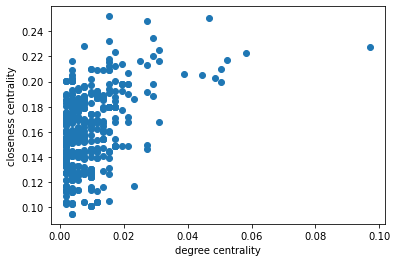

In [13]:
spearman = sp.spearmanr(list(deg_centr.values()),list(cl_centr.values()))[0]
kendal = sp.kendalltau(list(deg_centr.values()),list(cl_centr.values()))[0]
pearson = sp.pearsonr(list(deg_centr.values()),list(cl_centr.values()))[0]
print('Correlation coefficients - Degree Vs Closeness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(deg_centr.values()),list(cl_centr.values()))
plt.ylabel('closeness centrality')
plt.xlabel('degree centrality')

### Degree Vs Betweenness

Correlation coefficients - Degree Vs Betweenness

Pearson’s: 0.510186582896587
Spearman's: 0.6071015828501782
Kendall’s: 0.5030659638058488


Text(0.5, 0, 'degree centrality')

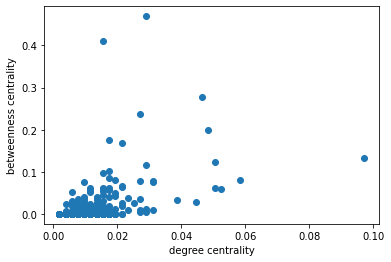

In [14]:
spearman = sp.spearmanr(list(deg_centr.values()),list(bet_centr.values()))[0]
kendal = sp.kendalltau(list(deg_centr.values()),list(bet_centr.values()))[0]
pearson = sp.pearsonr(list(deg_centr.values()),list(bet_centr.values()))[0]
print('Correlation coefficients - Degree Vs Betweenness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(deg_centr.values()),list(bet_centr.values()))
plt.ylabel('betweenness centrality')
plt.xlabel('degree centrality')

### Closeness Vs Betweenness

Correlation coefficients - Closeness Vs Betweenness

Pearson’s: 0.38422918644035287
Spearman's: 0.29257995969519734
Kendall’s: 0.22714248145921972


Text(0.5, 0, 'closeness centrality')

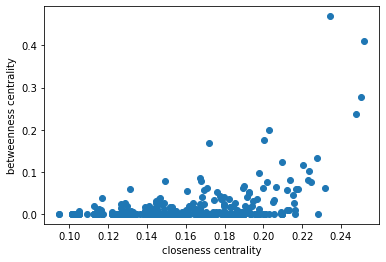

In [15]:
spearman = sp.spearmanr(list(cl_centr.values()),list(bet_centr.values()))[0]
kendal = sp.kendalltau(list(cl_centr.values()),list(bet_centr.values()))[0]
pearson = sp.pearsonr(list(cl_centr.values()),list(bet_centr.values()))[0]
print('Correlation coefficients - Closeness Vs Betweenness')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(cl_centr.values()),list(bet_centr.values()))
plt.ylabel('betweenness centrality')
plt.xlabel('closeness centrality')

## Distribution

In [139]:
degs = np.asarray([d for d in dict(pp.degree()).values()])
net_spacing = np.linspace(min(degs),max(degs),len(degs))
avg_deg = avg_degree(pp)
pp_pw = powerlaw.Fit(degs, discrete=True)

Calculating best minimal value for power law fit


In [162]:
print('Power-law exponent:', pp_pw.power_law.alpha)
print('Power-law error:', pp_pw.power_law.sigma)

Power-law exponent: 3.399573008316146
Power-law error: 0.22983741006723973


<function matplotlib.pyplot.show(close=None, block=None)>

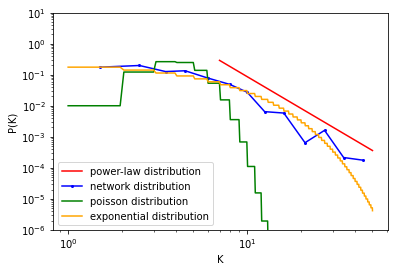

In [140]:
pp_pw.power_law.plot_pdf(color='r')
powerlaw.plot_pdf(degs,color='b',marker='o', markersize=2)
plt.plot(net_spacing, poisson_pdf(net_spacing, avg_deg), color='g')
plt.plot(net_spacing, exp_pdf(net_spacing, avg_deg), color='orange')
plt.legend(['power-law distribution', 'network distribution', 'poisson distribution', 'exponential distribution'])
plt.ylabel('P(K)')
plt.xlabel('K')
ax = plt.gca()
ax.set_ylim([0.000001, 10])
plt.show

In [141]:
pp_pw.distribution_compare('power_law', 'exponential')[0]

5.983965642326485

The network has a power-law distribution

## Plots

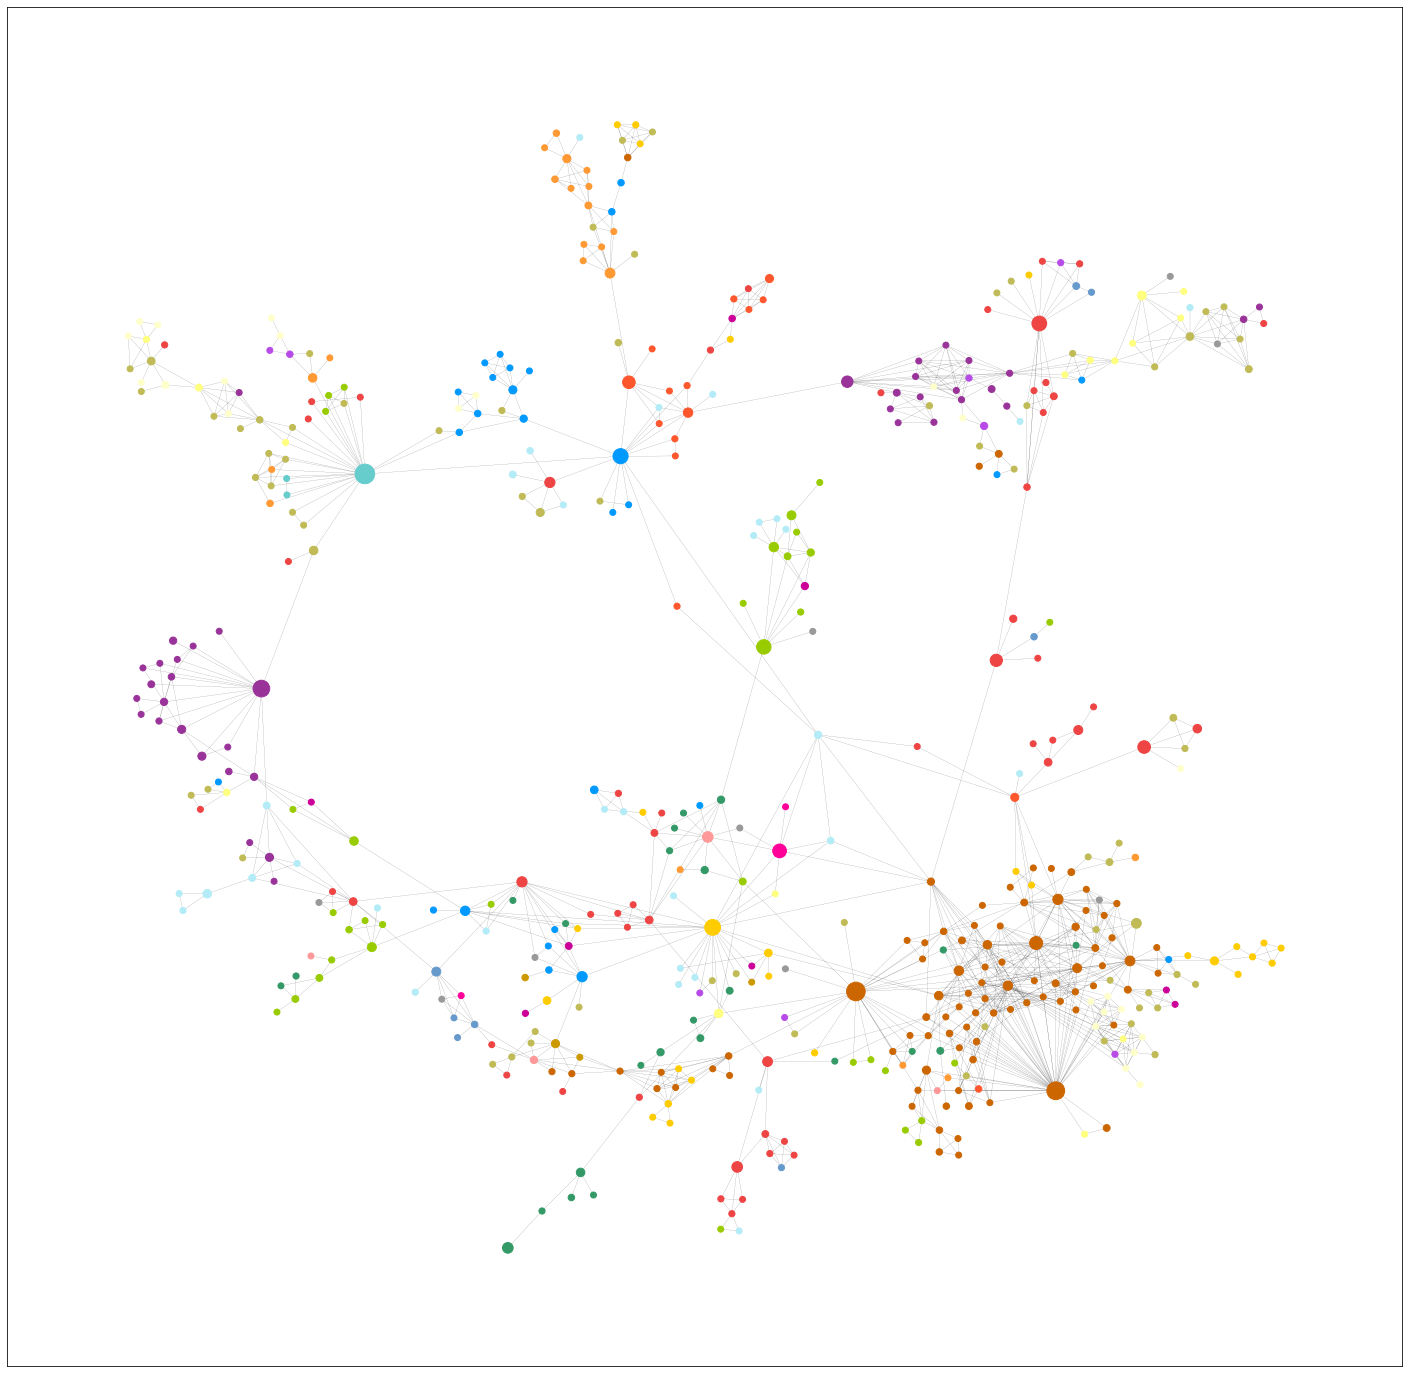

In [19]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=get_positions(pp), node_size=get_sizes(pp), with_labels=False, width=0.1)

In [20]:
new = create_subgraph_with_classes(pp, ['Ear,Nose,Throat','Neurological'])

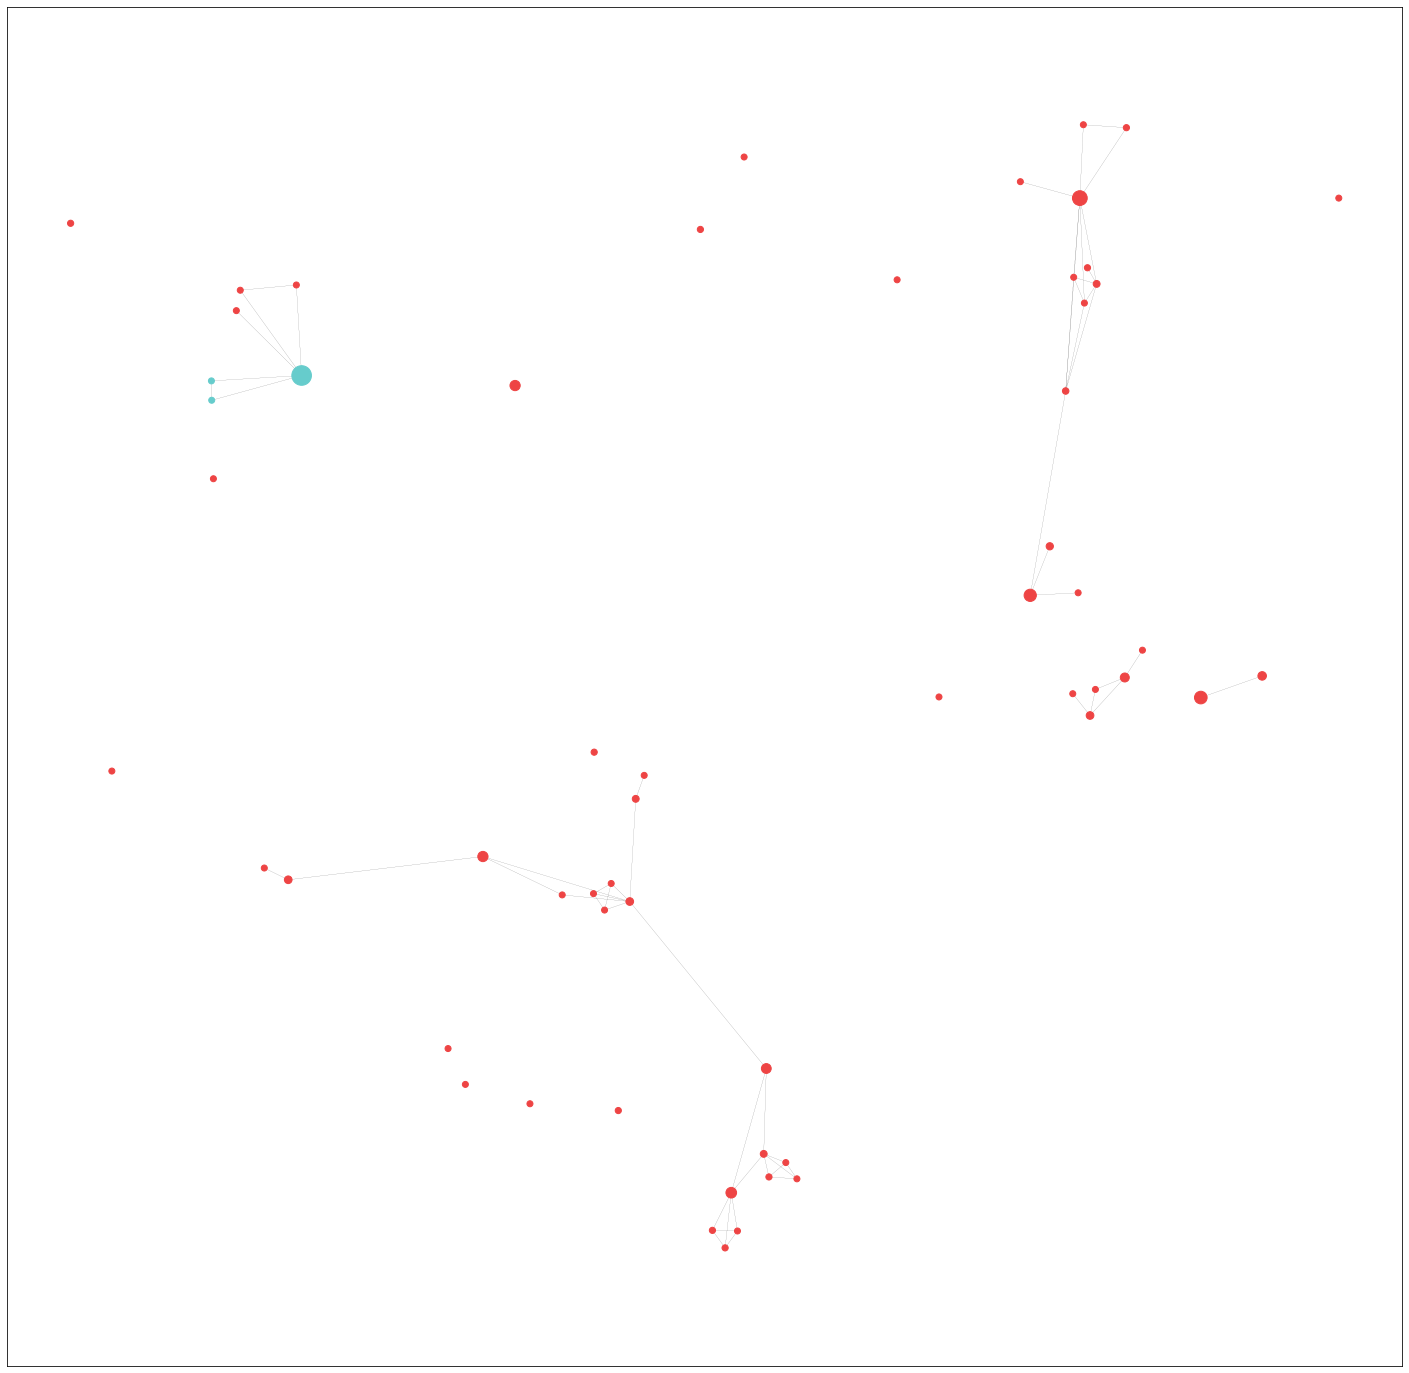

In [21]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(new, node_color=get_colours(new), pos=get_positions(new), node_size=get_sizes(new), with_labels=False, width=0.1)

In [22]:
encc = encoded_classes(pp)
nx.set_node_attributes(pp, list(encc.values())[0], list(encc.keys())[0])

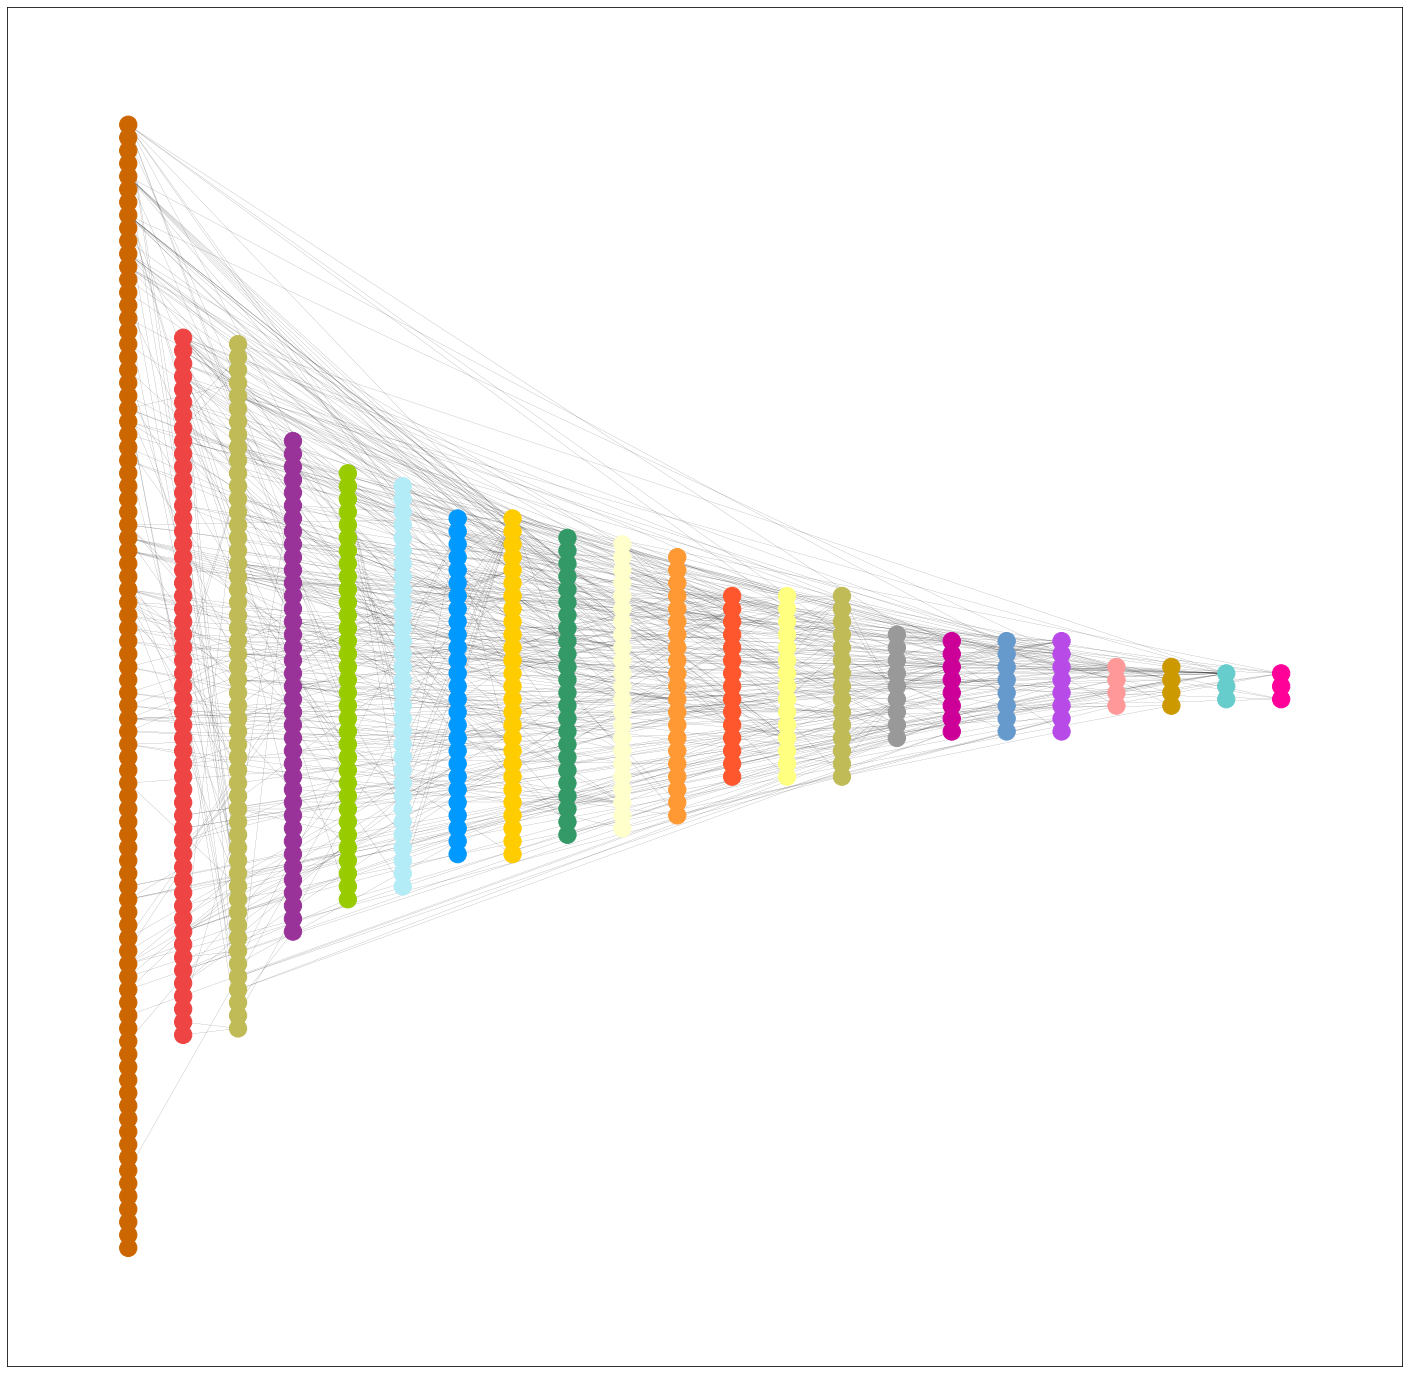

In [23]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(pp, node_color=get_colours(pp), pos=nx.drawing.multipartite_layout(pp, subset_key='encoded_class'), with_labels=False, width=0.1)

# METADATA SBM

In [24]:
meta_comm = get_communities_sequence(pp, 'disclass')
densities = get_densities(pp, meta_comm, len(meta_comm))
_, sizes = get_sorted_freq_graph(pp)
md_sbms = [nx.stochastic_block_model(sizes, densities) for i in range(100)]

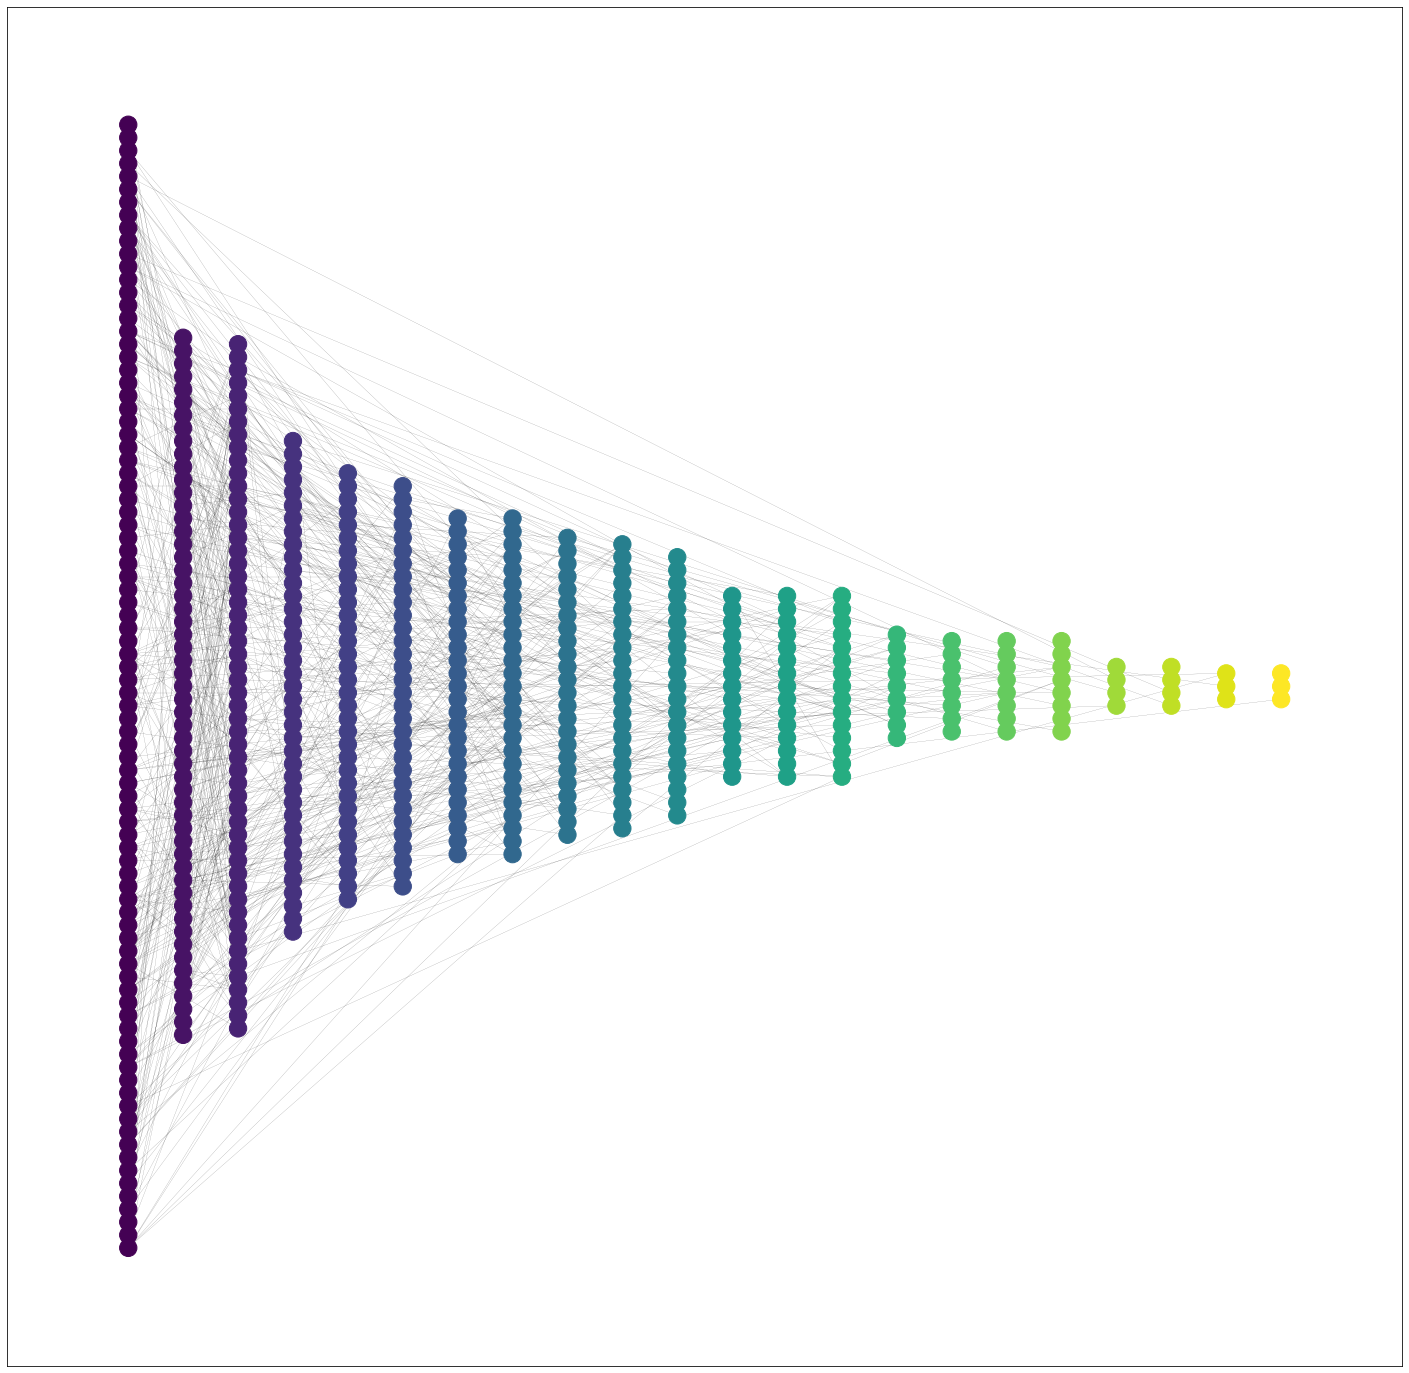

In [25]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(md_sbms[0], node_color=list(np.array(list(dict(md_sbms[0].nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(md_sbms[0], subset_key='block'), with_labels=False, width=0.1)

## Properties

In [26]:
comm_seq_md = [get_communities_sequence(n, 'block') for n in md_sbms]

In [27]:
mdsbm_properties = get_properties(md_sbms, comm_seq_md)

### Number of Communities

In [142]:
len(meta_comm)

22

### Average Degree


In [28]:
mdsbm_properties['average degree']

6.5126356589147285

### Average Clustering


In [29]:
mdsbm_properties['clustering']

0.04966968063374073

### Assortativity


In [30]:
mdsbm_properties['assortativity']

0.5020015472796421

### Coverage


In [31]:
mdsbm_properties['coverage']

0.631423926602587

### Performance


In [32]:
mdsbm_properties['performance']

0.9247797094904796

### Modularity


In [33]:
mdsbm_properties['modularity']

0.22298736557605395

# Greedy Modularity SBM

In [34]:
gr_comm = nx.algorithms.community.modularity_max.greedy_modularity_communities(pp)
densities = get_densities(pp, gr_comm, len(gr_comm))
sizes = get_sorted_freq_comm_size(gr_comm)
gr_sbms = [nx.stochastic_block_model(sizes, densities) for i in range(100)]

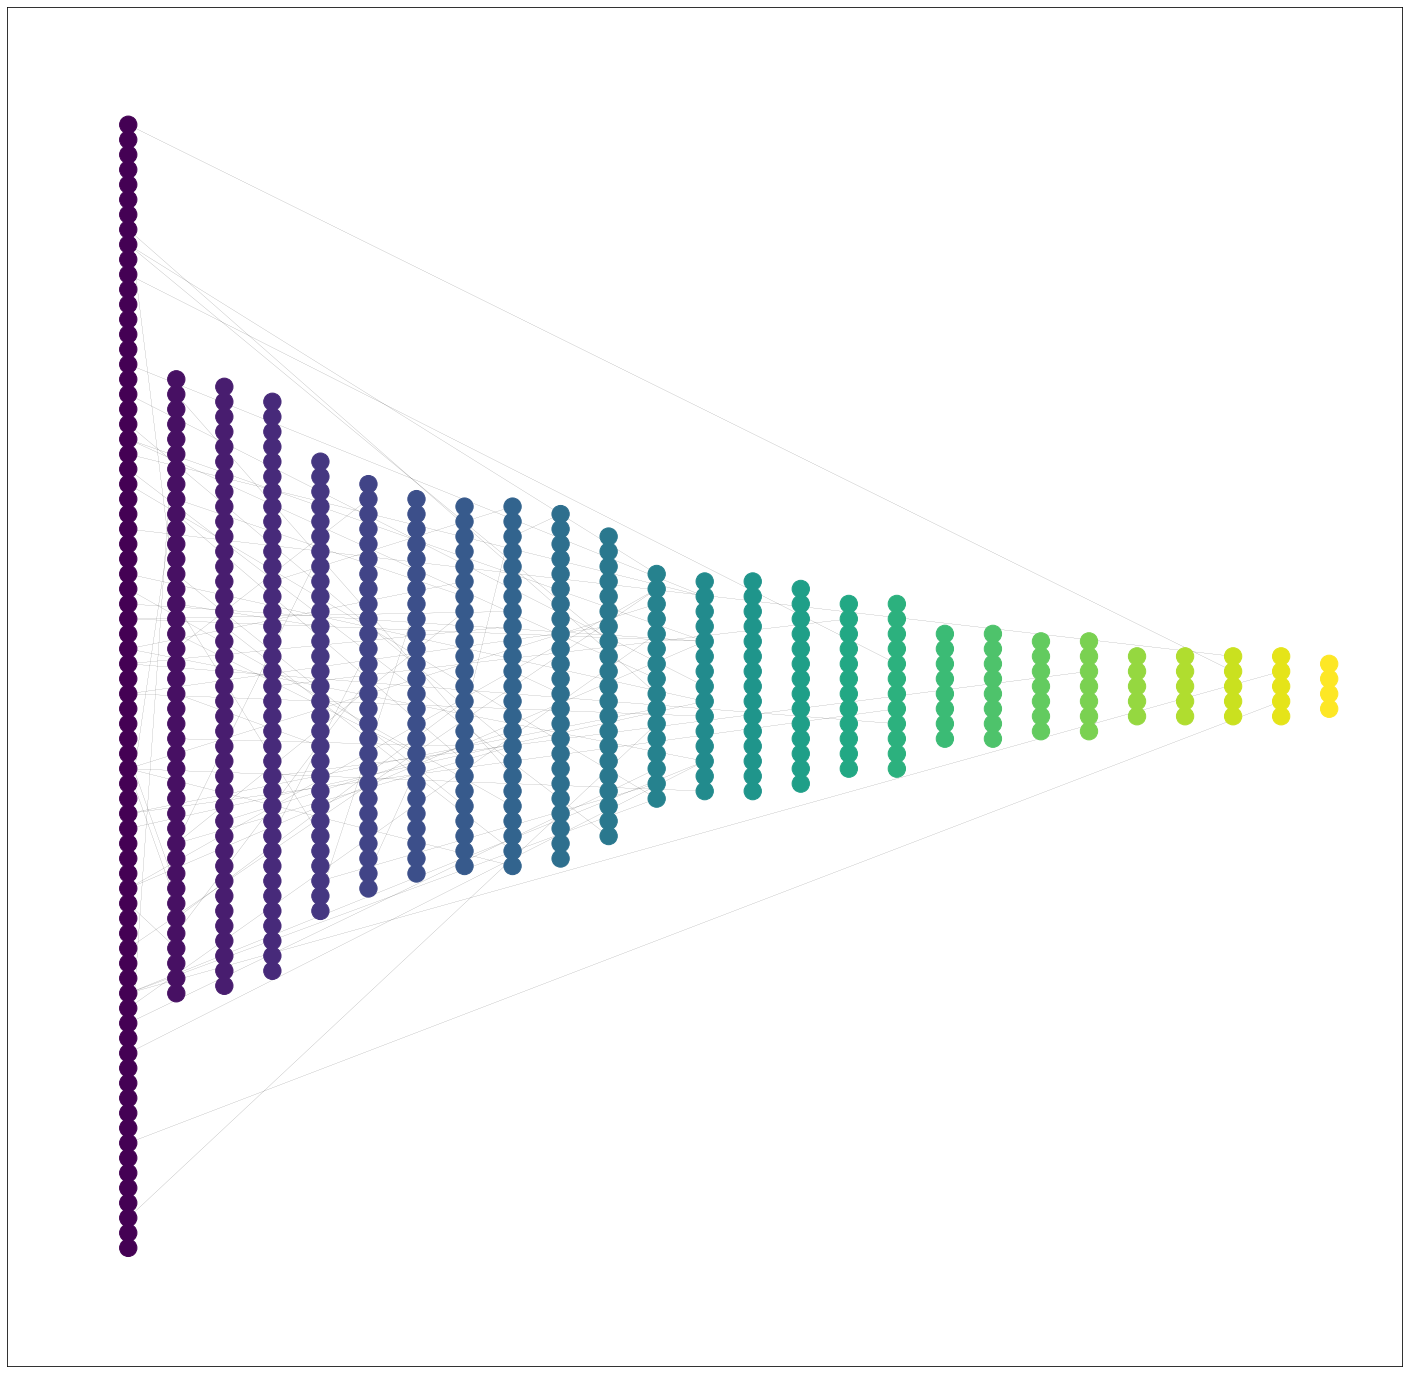

In [35]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(gr_sbms[0], node_color=list(np.array(list(dict(gr_sbms[0].nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(gr_sbms[0], subset_key='block'), with_labels=False, width=0.1)

## Properties

### Number of Communities

In [161]:
len(gr_comm)

26

In [37]:
comm_seq_gr = [get_communities_sequence(n, 'block') for n in gr_sbms]

In [38]:
grsbm_properties = get_properties(gr_sbms, comm_seq_gr)

### Average Degree


In [39]:
grsbm_properties['average degree']


3.895348837209302

### Average Clustering


In [40]:
grsbm_properties['clustering']


0.05041498883367928

### Assortativity


In [41]:
grsbm_properties['assortativity']


0.7050164140474873

### Coverage


In [42]:
grsbm_properties['coverage']


0.9181884464275428

### Performance


In [43]:
grsbm_properties['performance']


0.9444384736960939

### Modularity


In [44]:
grsbm_properties['modularity']

0.4531184712254721

# Label Propagation SBM

In [45]:
lp_comm = nx.algorithms.community.label_propagation.label_propagation_communities(pp)
densities = get_densities(pp, lp_comm, len(lp_comm))
sizes = get_sorted_freq_comm_size(lp_comm)
lp_sbms = [nx.stochastic_block_model(sizes, densities) for i in range(100)]

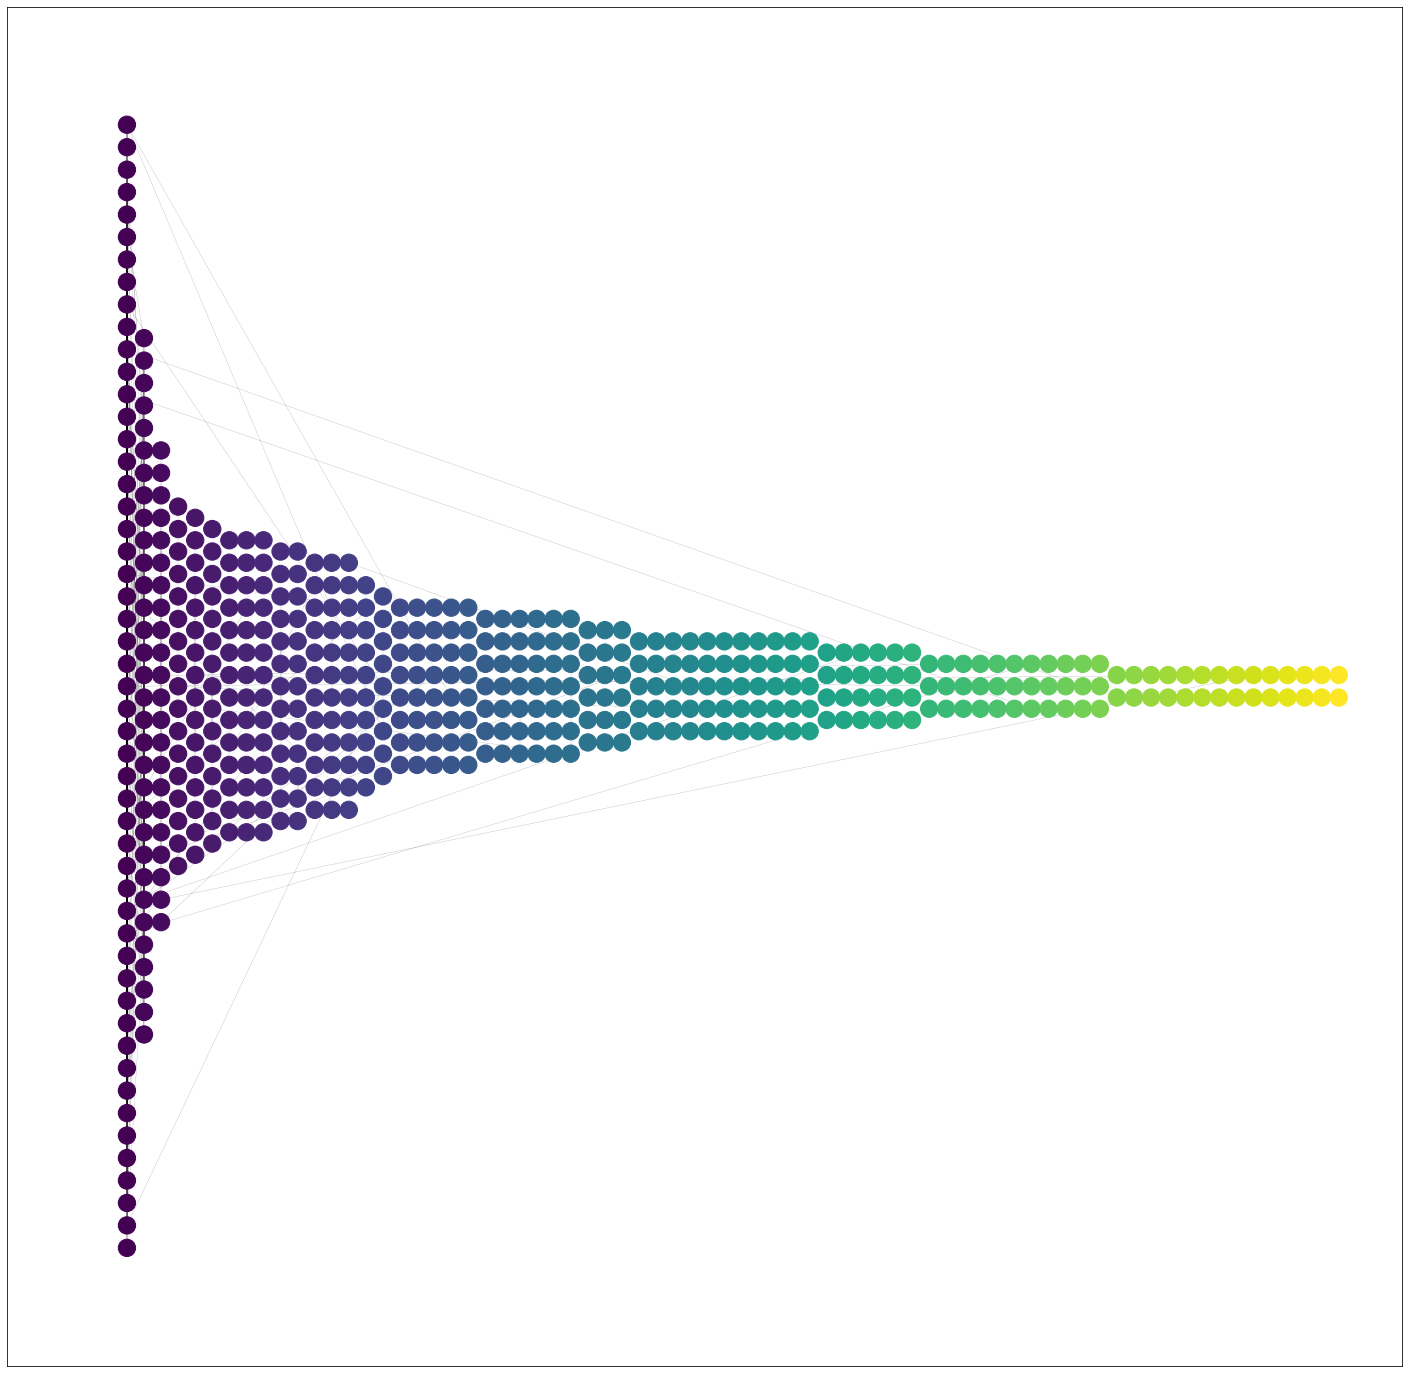

In [46]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(lp_sbms[0], node_color=list(np.array(list(dict(lp_sbms[0].nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(lp_sbms[0], subset_key='block'), with_labels=False, width=0.1)

## Properties

In [47]:
comm_seq_lp = [get_communities_sequence(n, 'block') for n in lp_sbms]

In [48]:
lpsbm_properties = get_properties(lp_sbms, comm_seq_lp)

### Number of Communities

In [49]:
len(lp_comm)

72

### Average Degree


In [50]:
lpsbm_properties['average degree']


1.2454651162790698

### Average Clustering


In [51]:
lpsbm_properties['clustering']


0.01451695811491783

### Assortativity


In [52]:
lpsbm_properties['assortativity']


0.40367056661201844

### Coverage


In [53]:
lpsbm_properties['coverage']


0.7490133277062675

### Performance


In [54]:
lpsbm_properties['performance']


0.9742979604124332

### Modularity

In [55]:
lpsbm_properties['modularity']

0.3416594130939897

# Girvan Newman SBM

In [102]:
import itertools

communities_generator = nx.algorithms.community.centrality.girvan_newman(pp)
gn = []
limited = itertools.takewhile(lambda c: len(c) <= 22, communities_generator)
for communities in limited:
    gn.append(communities)
gn_comm = gn[-1]    
densities = get_densities(pp, gn_comm, len(gn_comm))
sizes = get_sorted_freq_comm_size(gn_comm)
gn_sbms = [nx.stochastic_block_model(sizes, densities) for i in range(100)]

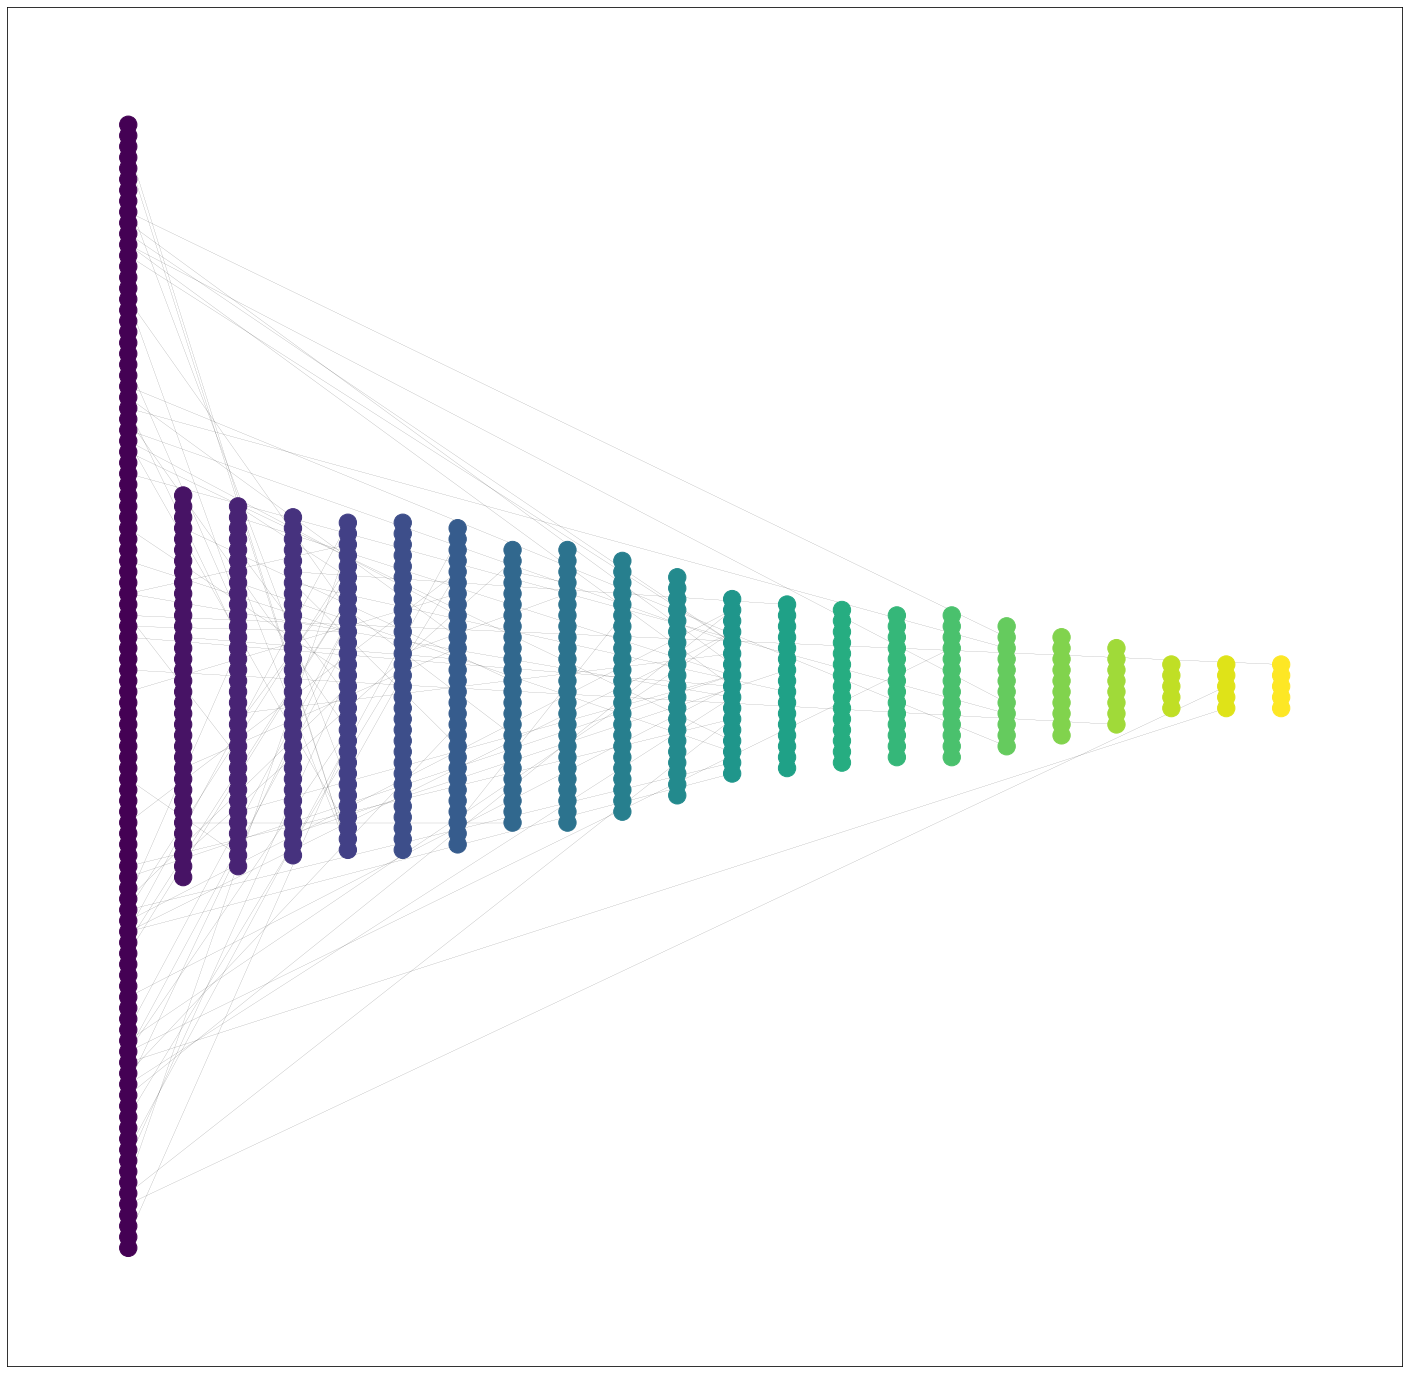

In [57]:
plt.figure(figsize=(25,25)) 
nx.draw_networkx(gn_sbms[0], node_color=list(np.array(list(dict(gn_sbms[0].nodes.data('block')).values()))),pos=nx.drawing.multipartite_layout(gn_sbms[0], subset_key='block'), with_labels=False, width=0.1)

## Properties

In [58]:
comm_seq_gn = [get_communities_sequence(n, 'block') for n in gn_sbms]

In [59]:
gnsbm_properties = get_properties(gn_sbms, comm_seq_gn)

### Number of Communities

In [60]:
len(gn_comm)

22

### Average Degree


In [61]:
gnsbm_properties['average degree']


7.48313953488372

### Average Clustering


In [62]:
gnsbm_properties['clustering']


0.07401766904405345

### Assortativity


In [63]:
gnsbm_properties['assortativity']


0.73342705391677

### Coverage


In [64]:
gnsbm_properties['coverage']


0.9579085674417698

### Performance


In [65]:
gnsbm_properties['performance']


0.9361189884849854

### Modularity

In [66]:
gnsbm_properties['modularity']

0.21881597001352088

# SBM Centrality comparison

## MetaData Vs Greedy Modularity

### Degree Centrality

Correlation coefficients - degree Centrality

Pearson’s: 0.9262254053432242
Spearman's: 0.915715081087308
Kendall’s: 0.7372385607161459


Text(0, 0.5, 'Greedy Modularity SBM degree centrality')

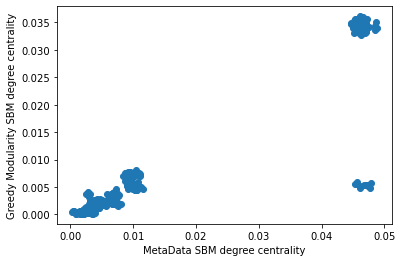

In [152]:
spearman = sp.spearmanr(list(grsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
kendal = sp.kendalltau(list(grsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
pearson = sp.pearsonr(list(grsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
print('Correlation coefficients - degree Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['degree centrality']),grsbm_properties['degree centrality'])
plt.xlabel('MetaData SBM degree centrality')
plt.ylabel('Greedy Modularity SBM degree centrality')

### Closeness Centrality


Correlation coefficients - closeness Centrality

Pearson’s: 0.748559441277975
Spearman's: 0.6572453492520939
Kendall’s: 0.46263264845337543


Text(0, 0.5, 'Greedy Modularity SBM closeness centrality')

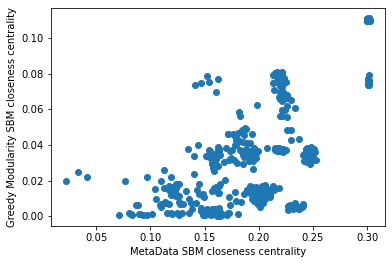

In [153]:
spearman = sp.spearmanr(list(grsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
kendal = sp.kendalltau(list(grsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
pearson = sp.pearsonr(list(grsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
print('Correlation coefficients - closeness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['closeness centrality']),grsbm_properties['closeness centrality'])
plt.xlabel('MetaData SBM closeness centrality')
plt.ylabel('Greedy Modularity SBM closeness centrality')

### Betweenness Centrality

Correlation coefficients - betweenness Centrality

Pearson’s: 0.7082975085997295
Spearman's: 0.8218962397031349
Kendall’s: 0.6239760769389546


Text(0, 0.5, 'Greedy Modularity SBM betweenness centrality')

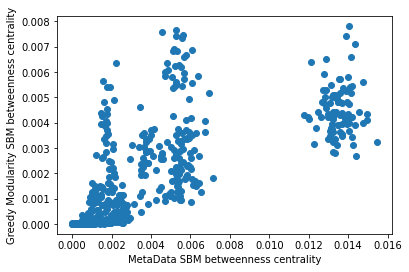

In [154]:
spearman = sp.spearmanr(list(grsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
kendal = sp.kendalltau(list(grsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
pearson = sp.pearsonr(list(grsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
print('Correlation coefficients - betweenness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['betweenness centrality']),grsbm_properties['betweenness centrality'])
plt.xlabel('MetaData SBM betweenness centrality')
plt.ylabel('Greedy Modularity SBM betweenness centrality')

## MetaData Vs Label Propagation

### Degree Centrality

Correlation coefficients - degree Centrality

Pearson’s: 0.9411456366676667
Spearman's: 0.8341416576058375
Kendall’s: 0.6426764103550642


Text(0, 0.5, 'Label Propagation SBM degree centrality')

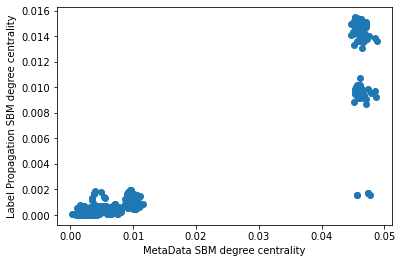

In [155]:
spearman = sp.spearmanr(list(lpsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
kendal = sp.kendalltau(list(lpsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
pearson = sp.pearsonr(list(lpsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
print('Correlation coefficients - degree Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['degree centrality']),lpsbm_properties['degree centrality'])
plt.xlabel('MetaData SBM degree centrality')
plt.ylabel('Label Propagation SBM degree centrality')

### Closeness Centrality


Correlation coefficients - closeness Centrality

Pearson’s: 0.6802377723561227
Spearman's: 0.5425424113802547
Kendall’s: 0.38790866775076566


Text(0, 0.5, 'Label Propagation SBM closeness centrality')

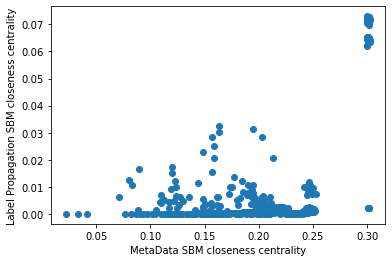

In [156]:
spearman = sp.spearmanr(list(lpsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
kendal = sp.kendalltau(list(lpsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
pearson = sp.pearsonr(list(lpsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
print('Correlation coefficients - closeness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['closeness centrality']),lpsbm_properties['closeness centrality'])
plt.xlabel('MetaData SBM closeness centrality')
plt.ylabel('Label Propagation SBM closeness centrality')

### Betweenness Centrality

Correlation coefficients - betweenness Centrality

Pearson’s: 0.8504215226962721
Spearman's: 0.7763188633219955
Kendall’s: 0.5998867327858676


Text(0, 0.5, 'Label Propagation SBM betweenness centrality')

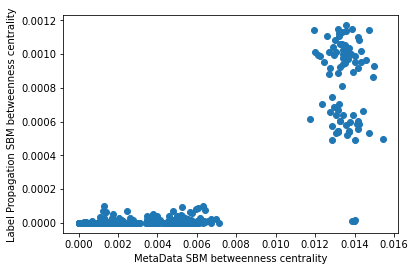

In [157]:
spearman = sp.spearmanr(list(lpsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
kendal = sp.kendalltau(list(lpsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
pearson = sp.pearsonr(list(lpsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
print('Correlation coefficients - betweenness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['betweenness centrality']),lpsbm_properties['betweenness centrality'])
plt.xlabel('MetaData SBM betweenness centrality')
plt.ylabel('Label Propagation SBM betweenness centrality')

## MetaData Vs Girvan Newman

### Degree Centrality

Correlation coefficients - degree Centrality

Pearson’s: 0.9105443342413411
Spearman's: 0.8566272317463102
Kendall’s: 0.6559212738539466


Text(0, 0.5, 'Girvan Newman SBM degree centrality')

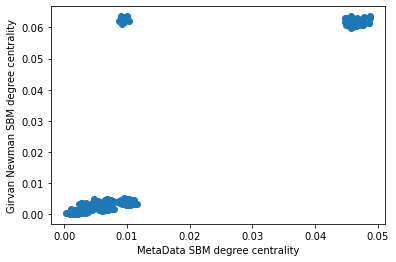

In [158]:
spearman = sp.spearmanr(list(gnsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
kendal = sp.kendalltau(list(gnsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
pearson = sp.pearsonr(list(gnsbm_properties['degree centrality']),list(mdsbm_properties['degree centrality']))[0]
print('Correlation coefficients - degree Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['degree centrality']),gnsbm_properties['degree centrality'])
plt.xlabel('MetaData SBM degree centrality')
plt.ylabel('Girvan Newman SBM degree centrality')

### Closeness Centrality


Correlation coefficients - closeness Centrality

Pearson’s: 0.6762302043186748
Spearman's: 0.5954790673218058
Kendall’s: 0.41240310077519376


Text(0, 0.5, 'Girvan Newman SBM closeness centrality')

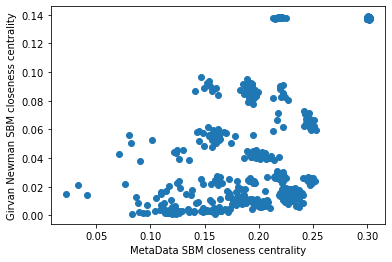

In [159]:
spearman = sp.spearmanr(list(gnsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
kendal = sp.kendalltau(list(gnsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
pearson = sp.pearsonr(list(gnsbm_properties['closeness centrality']),list(mdsbm_properties['closeness centrality']))[0]
print('Correlation coefficients - closeness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['closeness centrality']),gnsbm_properties['closeness centrality'])
plt.xlabel('MetaData SBM closeness centrality')
plt.ylabel('Girvan Newman SBM closeness centrality')

### Betweenness Centrality

Correlation coefficients - betweenness Centrality

Pearson’s: 0.5418001153388338
Spearman's: 0.6548043182323614
Kendall’s: 0.4860400505540449


Text(0, 0.5, 'Girvan Newman SBM betweenness centrality')

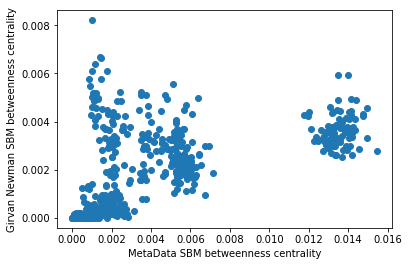

In [160]:
spearman = sp.spearmanr(list(gnsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
kendal = sp.kendalltau(list(gnsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
pearson = sp.pearsonr(list(gnsbm_properties['betweenness centrality']),list(mdsbm_properties['betweenness centrality']))[0]
print('Correlation coefficients - betweenness Centrality')
print()
print("Pearson’s:", pearson)
print("Spearman's:", spearman)
print("Kendall’s:", kendal)

plt.scatter(list(mdsbm_properties['betweenness centrality']),gnsbm_properties['betweenness centrality'])
plt.xlabel('MetaData SBM betweenness centrality')
plt.ylabel('Girvan Newman SBM betweenness centrality')